## **Thresholding**

In [80]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as im
import os 
import pandas as pd
import cv2 as cv
from skimage.color import rgb2gray
import math
import random
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [81]:
folder = [
    "dataset/busuk/",
    "dataset/segar/",
    "dataset/setengah segar/"
]
data = []
labels = []
fileName = []
for i in folder:
    label = i.split('/')[-2].lower().replace(" ", "_")
    dataset = os.listdir(i)
    for file in dataset:
        image_path = os.path.join(i, file)
        nama = os.path.splitext(file)[0]
        temp = cv.imread(image_path)
        if temp is None:
            print(f"Error: Tidak dapat memuat gambar di {image_path}")
            continue
        data.append(temp)
        labels.append(label)
        fileName.append(nama)

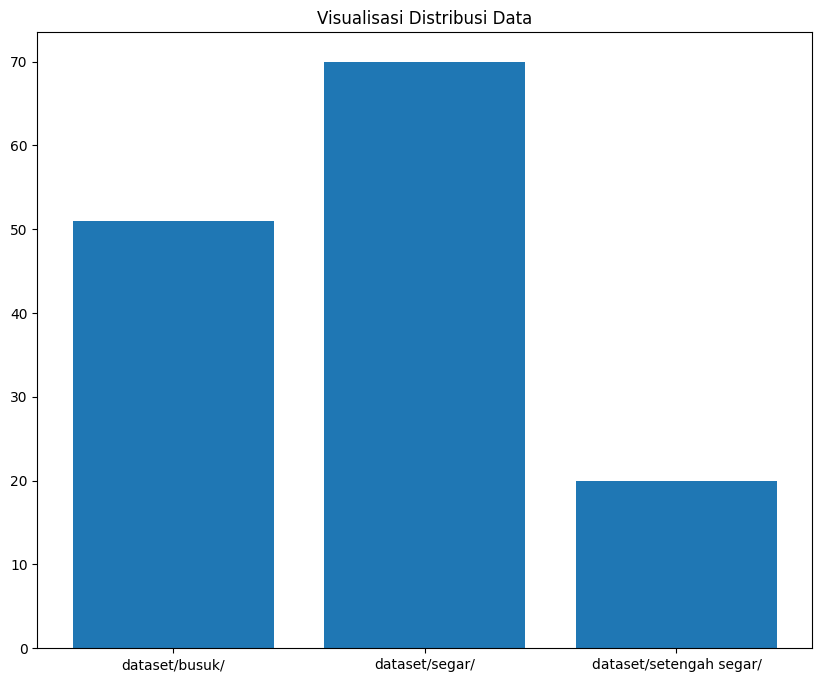

In [82]:
count_data = {}
for i in folder:
    count_data[i] = len(os.listdir(i))

plt.figure(figsize=(10, 8))
plt.bar(count_data.keys(), count_data.values())
plt.title('Visualisasi Distribusi Data')
plt.show()

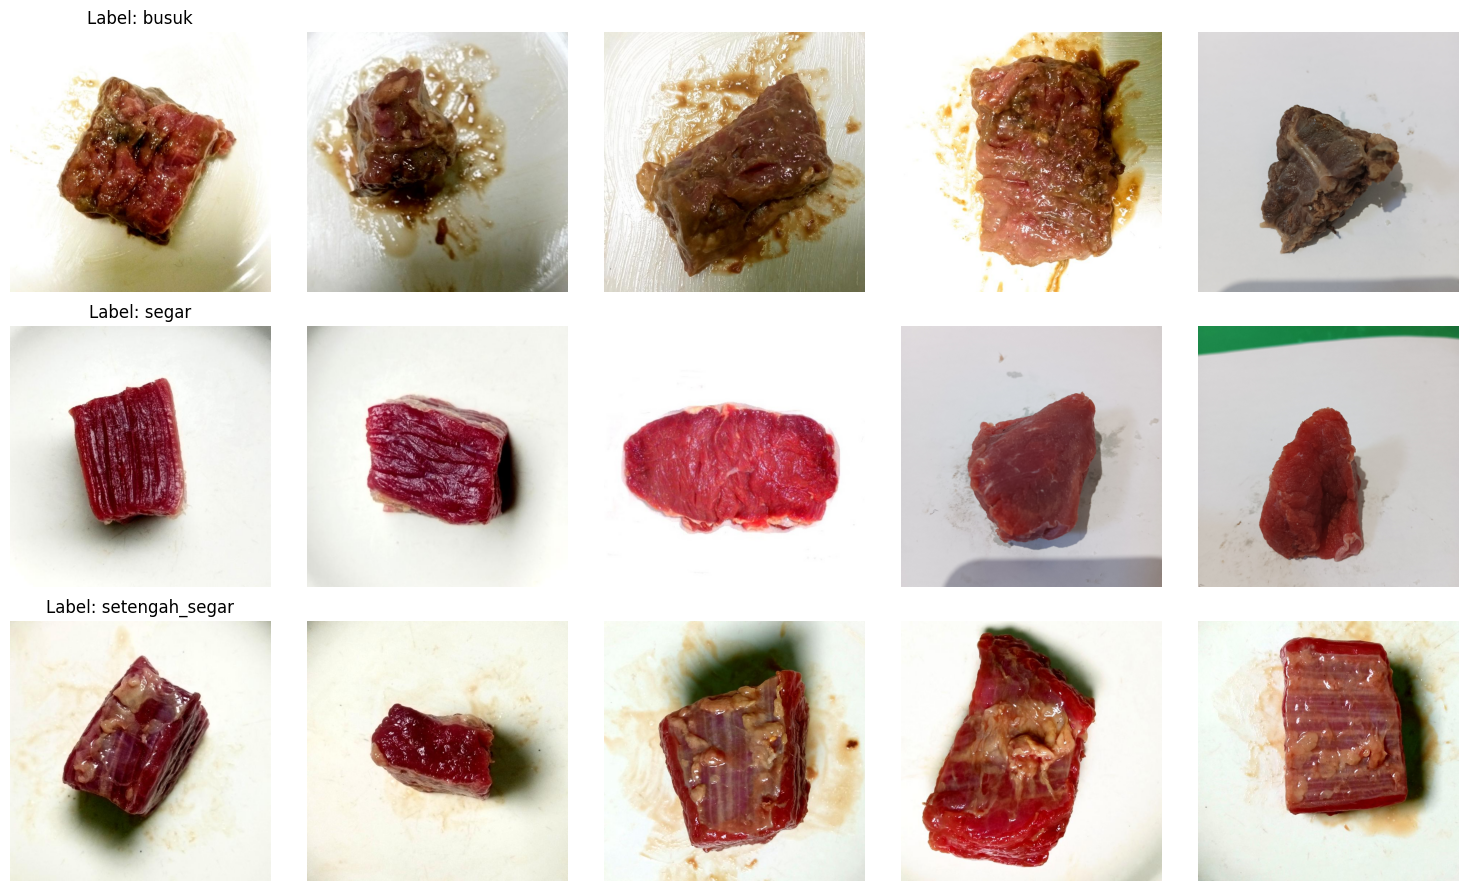

In [83]:
def plot_samples(data, label, num_samples=5):
    unique_labels = np.unique(label)
    fig, axes = plt.subplots(len(unique_labels), num_samples, figsize=(num_samples*3, len(unique_labels)*3))
    for i, j in enumerate(unique_labels):
        indices = [idx for idx, l in enumerate(label) if l == j]
        sample_indices = random.sample(indices, num_samples)
        for k, sample_idx in enumerate(sample_indices):
            if data[sample_idx].ndim == 2: 
                axes[i, k].imshow(data[sample_idx], cmap='gray')
            elif data[sample_idx].shape[2] == 3:
                image = data[sample_idx][:, :, ::-1]
                axes[i, k].imshow(image)
            axes[i, k].axis('off')
            if k == 0:
                axes[i, k].set_title(f'Label: {j}')

    plt.tight_layout()
    plt.show()

plot_samples(data, labels)

In [84]:
data = []
labels = []
fileName = []
for i in folder:
    label = i.split('/')[-2].lower().replace(" ", "_")
    dataset = os.listdir(i)
    for file in dataset:
        image_path = os.path.join(i, file)
        nama = os.path.splitext(file)[0]
        temp = cv.imread(image_path)
        if temp is None:
            print(f"Error: Tidak dapat memuat gambar di {image_path}")
            continue
        grayimage = cv.cvtColor(temp, cv.COLOR_BGR2GRAY)
        data.append(grayimage)
        labels.append(label)
        fileName.append(nama)

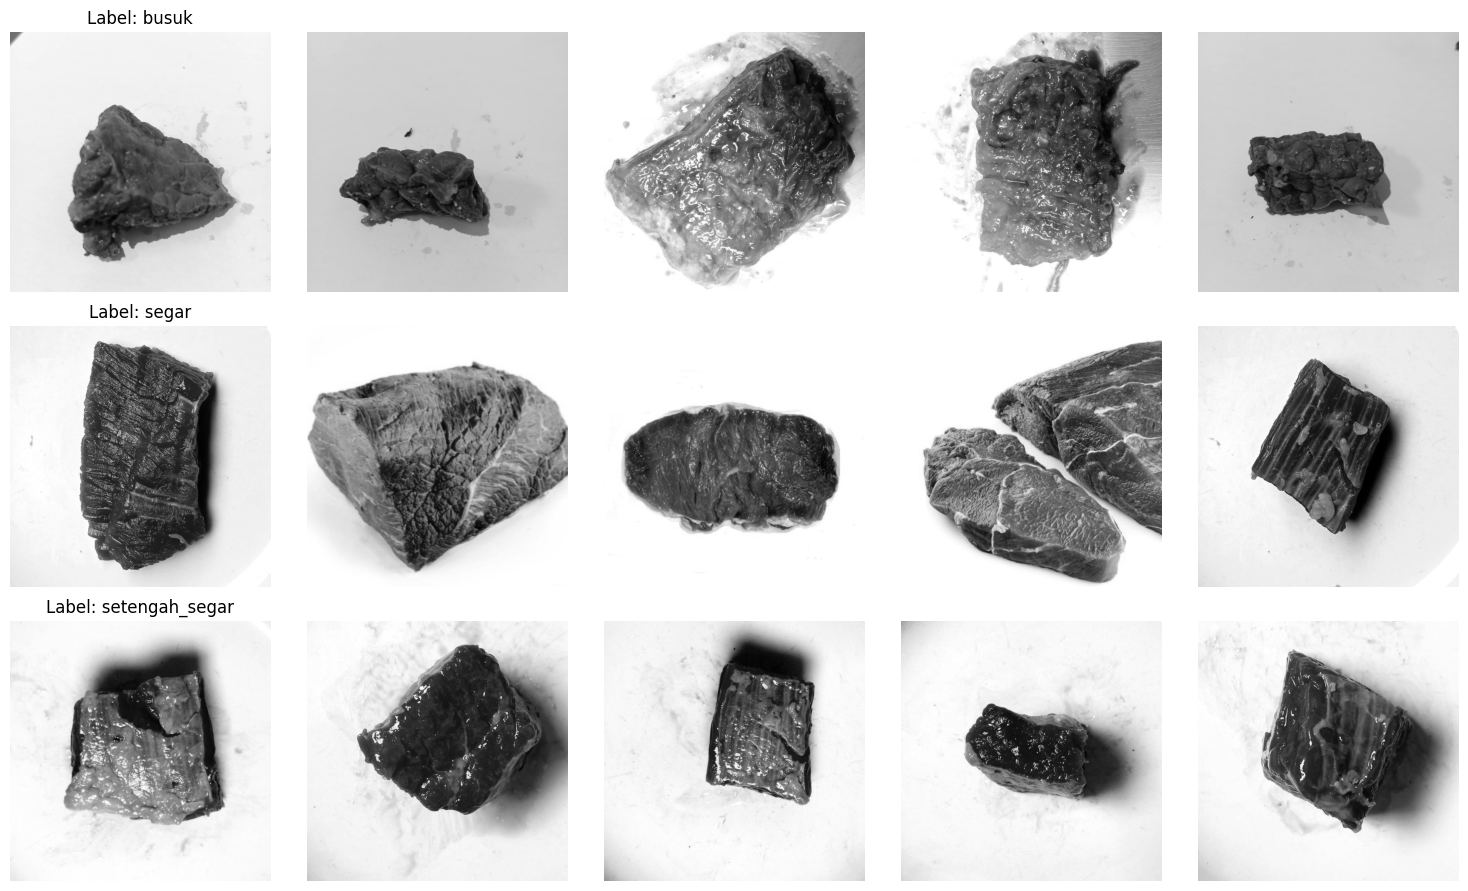

In [85]:
def plot_samples(data, label, num_samples=5):
    unique_labels = np.unique(label)
    fig, axes = plt.subplots(len(unique_labels), num_samples, figsize=(num_samples*3, len(unique_labels)*3))
    for i, j in enumerate(unique_labels):
        indices = [idx for idx, l in enumerate(label) if l == j]
        sample_indices = random.sample(indices, num_samples)
        for k, sample_idx in enumerate(sample_indices):
            if data[sample_idx].ndim == 2: 
                axes[i, k].imshow(data[sample_idx], cmap='gray')
            elif data[sample_idx].shape[2] == 3:
                image = data[sample_idx][:, :, ::-1]
                axes[i, k].imshow(image)
            axes[i, k].axis('off')
            if k == 0:
                axes[i, k].set_title(f'Label: {j}')

    plt.tight_layout()
    plt.show()

plot_samples(data, labels)

In [86]:
def preprocess_otsu(image):
    if len(image.shape) == 2:  # Jika gambar sudah grayscale
        gray_image = image
    else:
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, otsu_image = cv.threshold(gray_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    return otsu_image

In [87]:
preprocessed_path = 'dataset/preprocess/'
kategori = ['busuk', 'segar', 'setengah_segar']

if not os.path.exists(preprocessed_path):
    os.makedirs(preprocessed_path)

for i in kategori:
    kategori_path = os.path.join(preprocessed_path, i)
    if not os.path.exists(kategori_path):
        os.makedirs(kategori_path)

In [88]:
preprocessed_data_otsu = []
preprocessed_labels_otsu = []
for i, image in enumerate(data):
    label = labels[i]
    otsu_image = preprocess_otsu(image)
    preprocessed_data_otsu.append(otsu_image)
    preprocessed_labels_otsu.append(label)

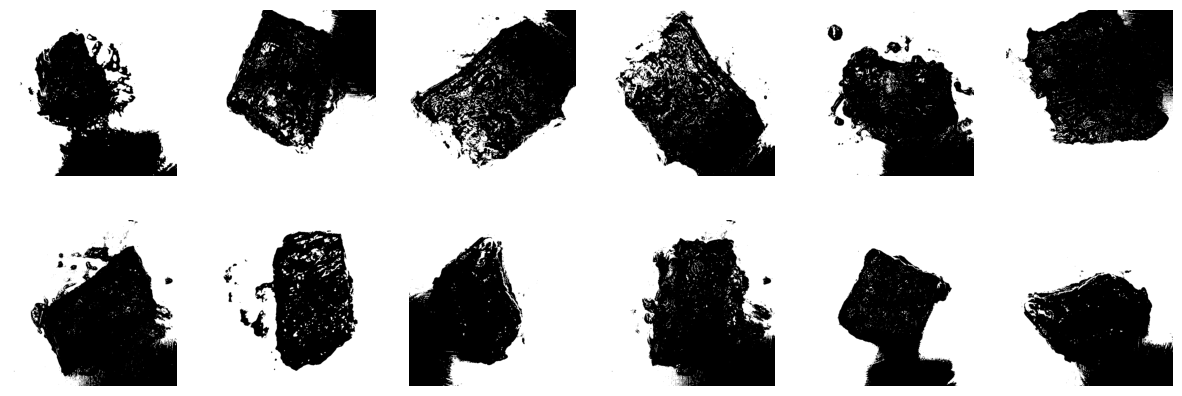

In [89]:
num_samples = min(len(preprocessed_data_otsu), 12)

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(2, 6, i+1)
    plt.imshow(preprocessed_data_otsu[i], cmap='gray')
    plt.axis('off')
plt.show()

In [90]:
jenis = {
    'busuk': 0,
    'segar': 1,
    'setengah_segar': 2
}

In [91]:
def extract_glcm_features(images, labels, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True):
    features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    angle_labels = ['0', '45', '90', '135']
    df_data = pd.DataFrame()
    for i, image in enumerate(images):
        image = image.astype(int)
        glcm = graycomatrix(image, distances, angles, levels, symmetric, normed)
        for feature in features:
            for angle, angle_label in zip(angles, angle_labels):
                feat_a = graycoprops(glcm, feature)[0, int(angle*4/np.pi)]
                df_data.loc[i, f'{feature}_{angle_label}'] = feat_a
        for angle, angle_label in zip(angles, angle_labels):
            asm = np.sum(glcm[:, :, 0, int(angle*4/np.pi)]**2)
            entropy = -np.sum(glcm[:, :, 0, int(angle*4/np.pi)]*np.log2(glcm[:, :, 0, int(angle*4/np.pi)] + np.finfo(float).eps))
            df_data.loc[i, f'asm_{angle_label}'] = asm
            df_data.loc[i, f'entropy_{angle_label}'] = entropy
        df_data.loc[i, 'label'] = jenis[labels[i]]
    return df_data



In [92]:
folder_baru = [
    "dataset/preprocess/busuk/",
    "dataset/preprocess/segar/",
    "dataset/preprocess/setengah_segar/"
]
data = []
labels = []
fileName = []
for i in folder:
    label = i.split('/')[-2].lower().replace(" ", "_")
    dataset = os.listdir(i)
    for file in dataset:
        image_path = os.path.join(i, file)
        nama = os.path.splitext(file)[0]
        temp = cv.imread(image_path)
        if temp is None:
            print(f"Error: Tidak dapat memuat gambar di {image_path}")
            continue
        grayimage = cv.cvtColor(temp, cv.COLOR_BGR2GRAY)
        data.append(grayimage)
        labels.append(label)
        fileName.append(nama)

In [93]:
# Memanggil fungsi dengan data yang telah dipreproses
df_glcm_otsu = extract_glcm_features(preprocessed_data_otsu, preprocessed_labels_otsu)

# Tampilkan data
df_glcm_otsu.head()

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,correlation_135,asm_0,entropy_0,asm_45,entropy_45,asm_90,entropy_90,asm_135,entropy_135,label
0,2599.357955,2736.687759,2416.711976,2802.644268,10.193561,10.732109,9.477302,10.990762,0.960026,0.957914,...,0.909700,0.484166,1.208018,0.482370,1.217326,0.487747,1.193580,0.481449,1.221833,0.0
1,3175.084353,3335.369917,3091.087413,3302.645341,12.451311,13.079882,12.121911,12.951550,0.951172,0.948707,...,0.898341,0.454031,1.280679,0.451724,1.291279,0.455153,1.275189,0.452175,1.289159,0.0
2,4976.534528,5522.208703,5222.083479,5056.961637,19.515822,21.655720,20.478759,19.831222,0.923469,0.915077,...,0.844215,0.430265,1.388372,0.423077,1.418052,0.426998,1.401921,0.429067,1.393037,0.0
3,5195.305507,5051.127023,4964.408654,5517.896162,20.373747,19.808341,19.468269,21.638808,0.920104,0.922321,...,0.830013,0.427349,1.400463,0.429148,1.392708,0.430429,1.387693,0.423138,1.417816,0.0
4,2919.809441,2994.552341,2792.235140,3061.269887,11.450233,11.743343,10.949942,12.004980,0.955098,0.953948,...,0.904953,0.461888,1.257112,0.460747,1.262297,0.463896,1.248077,0.459819,1.266754,0.0


In [94]:
df_glcm_otsu.to_csv('glcm_features_percobaan3.csv', index=False)
df_glcm = pd.read_csv('glcm_features_percobaan3.csv')

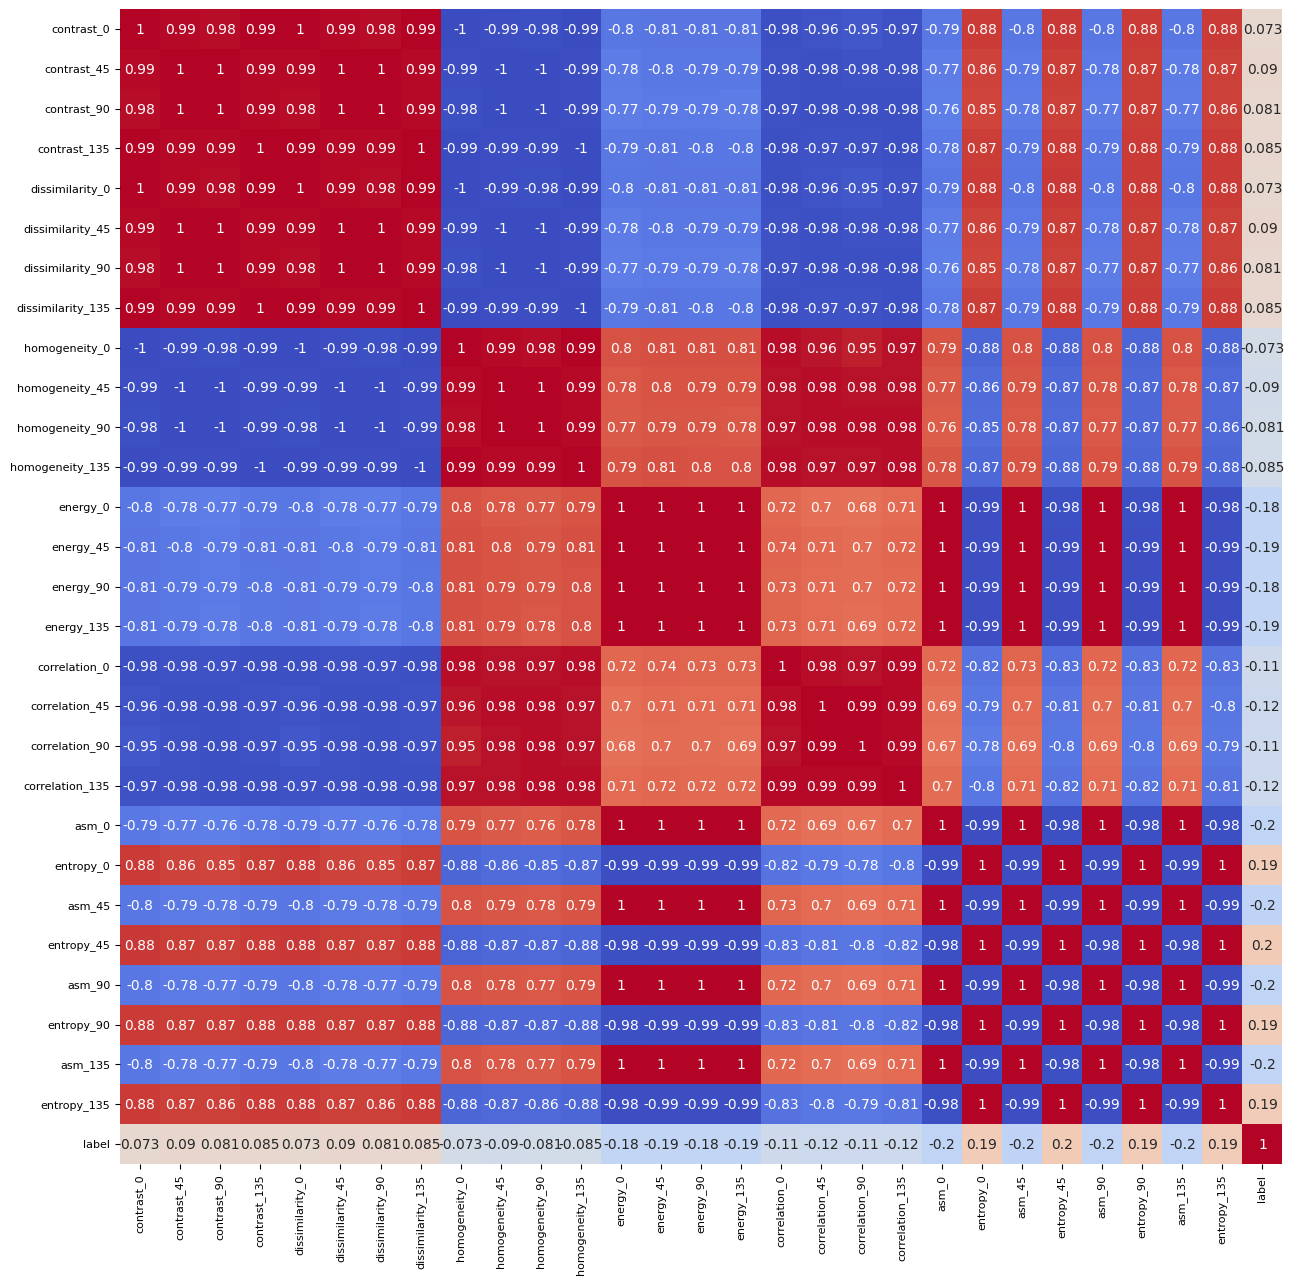

In [95]:
corr_glcm = df_glcm_otsu.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_glcm, annot=True, cmap='coolwarm', cbar=False)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.show()

In [96]:
x_otsu, y_otsu = df_glcm_otsu.drop('label', axis=1), df_glcm_otsu['label']
pca_otsu = PCA(n_components=25)
x_pca_otsu = pca_otsu.fit_transform(x_otsu)
x_train_otsu, x_test_otsu, y_train_otsu, y_test_otsu = train_test_split(x_pca_otsu, y_otsu, test_size=0.2, random_state=42)

In [97]:
scaler_otsu = StandardScaler()
x_train_otsu = scaler_otsu.fit_transform(x_train_otsu)
x_test_otsu = scaler_otsu.transform(x_test_otsu)

In [98]:
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(x_train_otsu, y_train_otsu)
y_pred_knn = knn.predict(x_test_otsu)
print('KNN Accuracy:', accuracy_score(y_test_otsu, y_pred_knn))

KNN Accuracy: 0.5172413793103449


In [99]:
svm = SVC(kernel='rbf', C=30, gamma='auto')
svm.fit(x_train_otsu, y_train_otsu)
y_pred_otsu = svm.predict(x_test_otsu)
print('SVM Accuracy:', accuracy_score(y_test_otsu, y_pred_otsu))

SVM Accuracy: 0.5172413793103449


In [100]:
rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, max_depth=50, min_samples_leaf=1, min_samples_split=2, bootstrap=False, criterion='gini')
rfc.fit(x_train_otsu, y_train_otsu)
y_pred_rfc = rfc.predict(x_test_otsu)
print('Random Forest Accuracy:', accuracy_score(y_test_otsu, y_pred_rfc))

Random Forest Accuracy: 0.7241379310344828


In [101]:
# Evaluate Models
model_dict = {
    'KNN': knn,
    'SVM': svm,
    'RF': rfc
}
df_eval = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'], index=model_dict.keys())


In [102]:
for model_name, model in model_dict.items():
    y_pred = model.predict(x_test_otsu)
    df_eval.loc[model_name, 'Accuracy'] = accuracy_score(y_test_otsu, y_pred)
    df_eval.loc[model_name, 'Precision'] = precision_score(y_test_otsu, y_pred, average='weighted')
    df_eval.loc[model_name, 'Recall'] = recall_score(y_test_otsu, y_pred, average='weighted')
    df_eval.loc[model_name, 'F1 Score'] = f1_score(y_test_otsu, y_pred, average='weighted')

print(df_eval)

     Accuracy Precision    Recall  F1 Score
KNN  0.517241  0.536125  0.517241  0.514437
SVM  0.517241  0.465609  0.517241  0.489551
RF   0.724138  0.708464  0.724138  0.708046


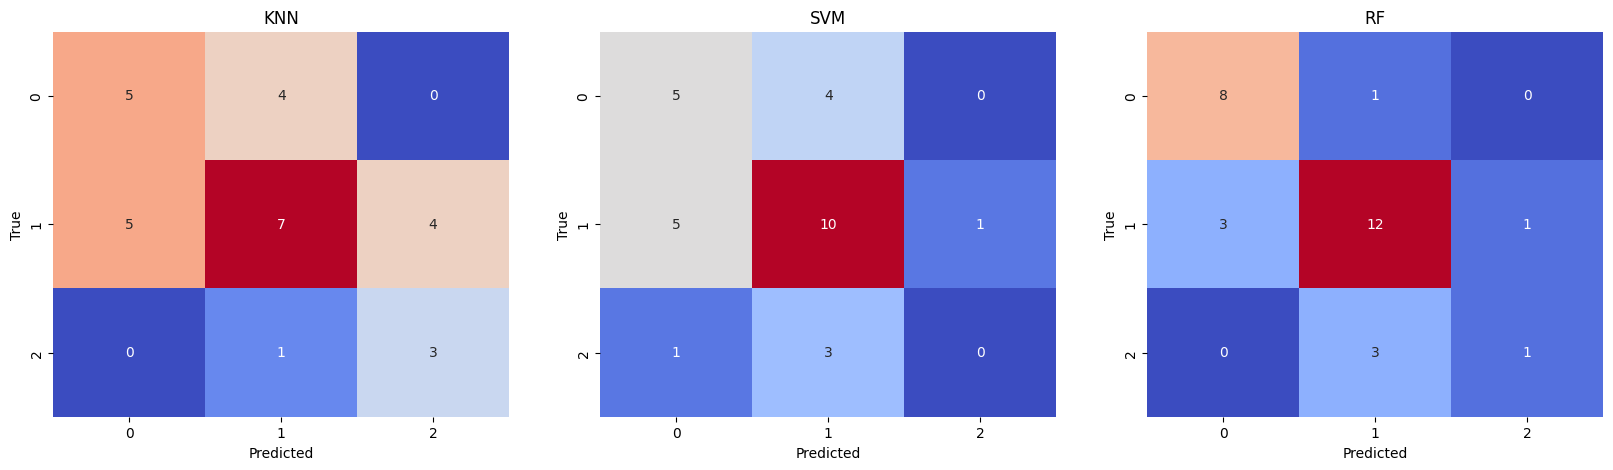

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, model_name in enumerate(model_dict.keys()):
    y_pred = model_dict[model_name].predict(x_test_otsu)
    cm = confusion_matrix(y_test_otsu, y_pred)
    sns.heatmap(cm, annot=True, cmap='coolwarm', cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')
    ax[i].set_title(model_name)
plt.show()